# Проект по построению модели для определения стоимости автомобиля
Даны исторические данные: технические характеристики, комплектации и цены автомобилей. Требуется построить модель для определения рыночной стоимости автомобиля. 

# Содержание
1. [Подготовка данных](#1)

    1.1. [Обзор данных](#11)
    
    1.2. [Обработка данных](#12)
    
    1.3. [Выводы по п.1](#13)
    
    
2. [Обучение моделей](#2)

    2.1. [Линейная регрессия](#21)
    
    2.2. [Решающее дерево](#22)
    
    2.3. [Случайный лес](#23)
    
    2.4. [CatBoost](#24)
    
    2.5. [LightGBM](#25)
    
    2.6. [Выводы по п.2](#26)
    
    
3. [Анализ моделей](#3)

    3.1. [Работа с тестовой выборкой](#31)
    
    3.2. [Выводы по п.3](#32)
    
    
4. [Общие выводы](#4)

# 1. Подготовка данных <a name="1"></a>

## 1.1. Обзор данных <a name="11"></a>
### Признаки
*DateCrawled* — дата скачивания анкеты из базы

*VehicleType* — тип автомобильного кузова

*RegistrationYear* — год регистрации автомобиля

*Gearbox* — тип коробки передач

*Power* — мощность (л. с.)

*Model* — модель автомобиля

*Kilometer* — пробег (км)

*RegistrationMonth* — месяц регистрации автомобиля

*FuelType* — тип топлива

*Brand* — марка автомобиля

*NotRepaired* — была машина в ремонте или нет

*DateCreated* — дата создания анкеты

*NumberOfPictures* — количество фотографий автомобиля

*PostalCode* — почтовый индекс владельца анкеты (пользователя)

*LastSeen* — дата последней активности пользователя

### Целевой признак
*Price* — цена (евро)

In [1]:
#Импорт библиотек
import pandas as pd
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

In [2]:
#Считываем датасет
data_auto = pd.read_csv("/datasets/autos.csv")

In [3]:
#Смотрим info
data_auto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [4]:
#Смотрим пропуски
data_auto.isnull().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [5]:
#Смотрим дубликаты
data_auto.duplicated().sum()

4

In [6]:
#Смотрим describe
data_auto.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [7]:
#Смотрим head
data_auto.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [8]:
#Смотрим tail
data_auto.tail()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26
354368,2016-03-20 19:41:08,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,NaN,2016-03-20 00:00:00,0,40764,2016-03-24 12:45:21


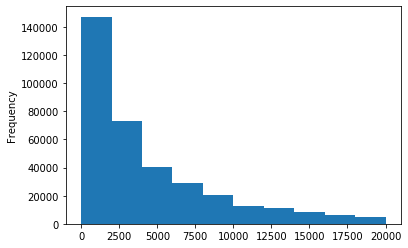

In [9]:
data_auto['Price'].plot(kind='hist')

In [10]:
#Смотрим годы регистрации
pd.set_option('display.max_rows', None)
data_auto['RegistrationYear'].value_counts() #unique()

2000    24490
1999    22728
2005    22109
2001    20124
2006    19900
2003    19763
2004    19611
2002    19092
1998    17899
2007    17183
2008    15391
1997    14666
2009    14503
1996    10835
2010    10764
2017    10441
2011     9909
1995     9607
2016     9599
2012     7178
1994     4841
2013     4131
2018     3959
1993     3438
1992     3002
1990     2806
1991     2762
2014     2537
1989     1318
2015     1302
1988      942
1985      756
1987      667
1980      588
1986      538
1983      430
1984      399
1970      333
1982      316
1978      285
1979      283
1981      263
1972      213
1960      188
1976      175
1977      173
1973      173
1974      169
1971      167
1975      143
1969      118
1966      113
1968      108
1910      101
1967       99
1965       82
1964       64
1963       57
1962       46
1961       41
1000       37
1959       32
1956       27
9999       26
2019       25
1958       25
1950       18
5000       17
1955       15
1953       14
1957       13
1951  

In [11]:
#Смортим уникальные значения по коробке передач
data_auto['Gearbox'].value_counts() #.unique()

manual    268251
auto       66285
Name: Gearbox, dtype: int64

In [12]:
#Смотрим уникальные значения по типу топлива
data_auto['FuelType'].value_counts()

petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

In [13]:
#Смотрим уникальные значения по типу топлива
data_auto['Brand'].value_counts()

volkswagen        77013
opel              39931
bmw               36914
mercedes_benz     32046
audi              29456
ford              25179
renault           17927
peugeot           10998
fiat               9643
seat               6907
mazda              5615
skoda              5500
smart              5246
citroen            5148
nissan             4941
toyota             4606
hyundai            3587
sonstige_autos     3374
volvo              3210
mini               3202
mitsubishi         3022
honda              2817
kia                2465
suzuki             2323
alfa_romeo         2314
chevrolet          1754
chrysler           1439
dacia               900
daihatsu            806
subaru              762
porsche             758
jeep                677
trabant             589
land_rover          545
daewoo              542
saab                526
jaguar              505
rover               486
lancia              471
lada                225
Name: Brand, dtype: int64

In [14]:
#Смотрим уникальные значения по модели
data_auto['Model'].value_counts()

golf                  29232
other                 24421
3er                   19761
polo                  13066
corsa                 12570
astra                 10809
passat                10146
a4                     9900
c_klasse               8312
5er                    7868
e_klasse               6785
a3                     6122
focus                  5874
fiesta                 5774
a6                     5541
twingo                 4953
transporter            4822
2_reihe                4816
fortwo                 4337
vectra                 4254
a_klasse               4193
mondeo                 3601
clio                   3546
1er                    3514
3_reihe                3493
touran                 3470
punto                  3347
zafira                 3044
megane                 2910
ka                     2702
ibiza                  2702
lupo                   2594
octavia                2108
fabia                  2080
cooper                 1950
clk                 

In [15]:
#Смотрим уникальные значения по кузову
data_auto['VehicleType'].value_counts()

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64

## 1.2. Обработка данных <a name="12"></a>

In [16]:
#Названия столбцов в нижний регистр
data_auto.columns = ['date_crawled','price','vehicle_type','registration_year','gearbox','power','model','kilometer','registration_month','fuel_type','brand','not_repaired','date_created','number_of_pictures','postal_code','last_seen']

In [17]:
#Удаляем дубликаты
data_auto = data_auto.drop_duplicates().reset_index(drop = True)

In [18]:
#Удаляем лишние для обучения признаки NumberOfPictures,RegistrationMonth, DateCrawled,DateCreated, LastSeen 
data_auto_wo_ft = data_auto.drop(['number_of_pictures','registration_month','last_seen','date_created','date_crawled'],axis=1)

In [19]:
#Удаляем пропуски
data_auto_wo_nan = data_auto_wo_ft.dropna(subset = ['vehicle_type','gearbox','model','fuel_type','not_repaired'])

In [20]:
#Удаляем записи со странными годами регистрации < 1929 и > 2016
data_auto_normregyear = data_auto_wo_nan.query('registration_year >= 1929 & registration_year <= 2016')
data_auto_normregyear['registration_year'].value_counts()

2006    16530
1999    16063
2005    15807
2004    15594
2003    15484
2001    15033
2002    14665
2000    14481
2007    14378
2008    13168
2009    12642
1998    12233
1997     9861
2010     9450
2011     8854
1996     7112
2012     6442
1995     5184
2013     3700
1994     3198
2014     2267
1993     2246
1992     2031
1991     1877
1990     1253
2015      985
1989      850
1988      610
1987      418
1986      349
1985      301
1983      280
1984      246
1982      208
1979      171
1978      166
1980      153
1981      149
2016      130
1972      121
1974      105
1977      104
1973      101
1976       97
1971       96
1970       74
1975       71
1969       59
1966       59
1967       54
1968       49
1965       40
1964       27
1963       27
1960       24
1961       19
1962       16
1959       11
1956        8
1958        7
1957        6
1955        6
1951        6
1950        6
1954        5
1953        5
1937        4
1952        3
1942        2
1930        2
1945        2
1943  

In [21]:
#Удаляем записи с ценой = 0
data_auto_normprice = data_auto_normregyear.query('price > 0')

In [22]:
# Переводим признаки gearbox и not_repaired из категорийных в численные техникой OHE
data_auto_normprice = pd.get_dummies(data_auto_normprice, columns = ['gearbox','not_repaired'], drop_first=True)
data_auto_normprice.head()

,price,vehicle_type,registration_year,power,model,kilometer,fuel_type,brand,postal_code,gearbox_manual,not_repaired_yes
3,1500,small,2001,75,golf,150000,petrol,volkswagen,91074,1,0
4,3600,small,2008,69,fabia,90000,gasoline,skoda,60437,1,0
5,650,sedan,1995,102,3er,150000,petrol,bmw,33775,1,1
6,2200,convertible,2004,109,2_reihe,150000,petrol,peugeot,67112,1,0
10,2000,sedan,2004,105,3_reihe,150000,petrol,mazda,96224,1,0


In [23]:
# Переводим признак vehicle_type,model,fuel_type,brand из категорийных в численные техникой OE
encoder = OrdinalEncoder()
data_auto_normprice[['vehicle_type','model','fuel_type','brand']] = encoder.fit_transform(data_auto_normprice[['vehicle_type','model','fuel_type','brand']])

data_auto_normprice.head()

,price,vehicle_type,registration_year,power,model,kilometer,fuel_type,brand,postal_code,gearbox_manual,not_repaired_yes
3,1500,5.0,2001,75,116.0,150000,6.0,37.0,91074,1,0
4,3600,5.0,2008,69,101.0,90000,2.0,31.0,60437,1,0
5,650,4.0,1995,102,11.0,150000,6.0,2.0,33775,1,1
6,2200,1.0,2004,109,8.0,150000,6.0,25.0,67112,1,0
10,2000,4.0,2004,105,10.0,150000,6.0,19.0,96224,1,0


In [24]:
#Разбиваем на признаки и целевой признак
target = data_auto_normprice['price']
features = data_auto_normprice.drop('price', axis=1)

In [25]:
#Разбиваем на обучающую и тестовую выборки
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=12345)

In [26]:
# Масштабируем признаки
numeric = list(features_train)

scaler = StandardScaler()
scaler.fit(features_train)

features_train = features_train.copy()
features_train[numeric] = scaler.transform(features_train[numeric])

features_test = features_test.copy()
features_test[numeric] = scaler.transform(features_test[numeric])

features_train.head()

,vehicle_type,registration_year,power,model,kilometer,fuel_type,brand,postal_code,gearbox_manual,not_repaired_yes
266010,0.350983,-0.975283,-0.482855,0.606328,0.61423,0.711233,0.213116,0.020159,0.512504,2.849488
313382,1.286710,0.166916,2.406190,0.817808,0.61423,0.711233,-1.475949,-1.327851,-1.951203,-0.350940
159498,0.350983,-1.138455,-0.439081,-0.352378,0.61423,0.711233,0.289892,0.138349,0.512504,2.849488
345083,0.350983,0.003744,-0.329648,0.916498,0.61423,0.711233,1.287976,-0.788198,0.512504,2.849488
65096,-0.116881,-0.485769,-0.110781,0.112877,0.61423,0.711233,1.287976,-0.674654,0.512504,2.849488


## 1.3. Выводы по п.1 <a name="13"></a>

Проанализировали набор данных, обнаружили следующие недостатки:
- Пропуски в признаках VehicleType (тип кузова), Gearbox(тип коробки передач), Model (модель автомобиля), FuelType (тип топлива), NotRepaired (был ремонт или нет).
- Нереальные значения в признаке RegistrationYear (год регистрации), например 8455 или 1688.
- Нулевые значения в целевом признаке Price.
- Есть дублирующиеся записи.

Сделали следующую подготовку данных:
- Перевели названия столбцов в нижний регистр.
- Удалили дубликаты.
- Удалили лишние для обучения признаки NumberOfPictures, RegistrationMonth, DateCrawled, DateCreated, LastSeen (поскольку все анкеты были выгружены в период марта-апреля 2016, признаки дат для обучения модели предсказаниям цен с учетом инфляции можно отбросить).
- Удалили записи с пропусками в признаках VehicleType, Gearbox, Model, FuelType, NotRepaired (пропуски в NotRepaired можно было бы заполнить дополнительной категорией 'unknow', в этом случае, как показали расчеты, качество моделей было бы немного лучше, но тогда при работе CatBoost с тестовой выборкой падает JupiterHub и расчеты не довести до конца).
- Удалили записи со годами регистрации < 1929 и > 2016.
- Удалили записи с нулевой ценой.
- Перевели признаки Gearbox и NotRepaired из категорийных в численные техникой OHE.
- Перевели признаки VehicleType, Model, FuelType, Brand из категорийных в численные техникой OE.
- Разбили датасет на признаки и целевой признак.
- Разбили данные на обучающую и тестовую выборки.

# 2. Обучение моделей <a name="2"></a>

In [27]:
def RMSECalc(y,predictions):
    rmse = mean_squared_error(y,predictions)**0.5
    return rmse

In [28]:
#Сделали из RMSE свой скор, поскольку для cross_val_score есть только neg_mean_squared_error
my_rmse  = make_scorer(RMSECalc, greater_is_better=False)

## 2.1. Линейная регрессия <a name="21"></a>

In [29]:
%%time
#Линейная регрессия
model_lr = LinearRegression()
rmse_lr = cross_val_score(model_lr, 
                         features_train, 
                         target_train, 
                         scoring=my_rmse, 
                         cv=3,
                        ).mean()
print("Линейная регрессия")
print("RMSE =", rmse_lr)

Линейная регрессия
RMSE = -3348.575501167064
CPU times: user 300 ms, sys: 245 ms, total: 545 ms
Wall time: 516 ms


## 2.2. Решающее дерево <a name="22"></a>

In [30]:
#Подбираем оптимальную глубину для решающего дерева
#Закомментировано, чтобы по новой не прогонять - долго. Оптимальная глубина дерева - 13

#for depth in range(1, 30, 3):
#    model_dt = DecisionTreeRegressor(random_state=12345, 
#                                     max_depth=depth)
#    rmse_dt = cross_val_score(model_dt, 
#                             features_train, 
#                             target_train, 
#                             scoring=my_rmse, 
#                             cv=5,
#                            ).mean()
#    print('max_depth:',depth,'rmse:',rmse_dt)

# берем глубину дерева 13

In [31]:
%%time
#Обучаем модель решающим деревом с оптимальной глубиной дерева
best_model_dt = DecisionTreeRegressor(random_state=12345, 
                                 max_depth=13)

rmse_dt = cross_val_score(best_model_dt, 
                          features_train, 
                          target_train, 
                          scoring=my_rmse, 
                          cv=3,
                         ).mean()
print("Решающее дерево")
print("RMSE =", rmse_dt)

Решающее дерево
RMSE = -1946.509943576173
CPU times: user 1.62 s, sys: 0 ns, total: 1.62 s
Wall time: 1.62 s


## 2.3. Случайный лес <a name="23"></a>

In [32]:
#Подбираем глубину дерева в случайном лесу
#Закомментировано, чтобы по новой не прогонять - долго. Оптимальная глубина дерева для случайного леса - 19

#for depth in range(1, 30, 3):
#    model_rf = RandomForestRegressor(n_estimators=20, 
#                                     max_depth=depth, 
#                                     random_state=12345)
#    rmse_rf = cross_val_score(model_rf, 
#                             features_train, 
#                             target_train, 
#                             scoring=my_rmse, 
#                             cv=3,
#                            ).mean()
#    print('max_depth:',depth,'rmse:',rmse_rf)

#берем глубину дерева 19

In [33]:
# Подбираем количество деревьев в случайном лесу при глубине дерева = 19
#Закомментировано, чтобы по новой не прогонять - долго. Оптимальное количество деревьев для случайного леса - 200

#for estim in range(100, 251, 50):
#    model_rf = RandomForestRegressor(n_estimators=estim, 
#                                     max_depth=19, 
#                                     random_state=12345)
#    rmse_rf = cross_val_score(model_rf, 
#                             features_train, 
#                             target_train, 
#                             scoring=my_rmse, 
#                             cv=3,
#                            ).mean()
#    print('n_estimators:',estim,'rmse:',rmse_rf)

# берем количество деревьев 200

In [34]:
%%time
#Обучаем модель Случайным лесом с оптимальными глубиной дерева и количеством деревьев
best_model_rf = RandomForestRegressor(n_estimators=200, 
                                      max_depth=19, 
                                      random_state=12345)
rmse_rf = cross_val_score(best_model_rf, 
                          features_train, 
                          target_train, 
                          scoring=my_rmse, 
                          cv=3,
                         ).mean()
print("Случайный лес")
print("RMSE =", rmse_rf)

Случайный лес
RMSE = -1609.6505599570066
CPU times: user 4min 49s, sys: 1.68 s, total: 4min 51s
Wall time: 4min 52s


## 2.4. CatBoost <a name="24"></a>

In [35]:
#Удалим лишние переменные
del data_auto
del data_auto_wo_ft
del data_auto_wo_nan
del data_auto_normregyear
del data_auto_normprice

In [36]:
#Определяем оптимальную глубину деревьев для CatBoost
#Закомментировано, чтобы по новой не прогонять - долго. Оптимальная глубина дерева для CatBoost - 16

#for best_depth in range(6, 17, 5):
#    model_cb = CatBoostRegressor(loss_function = 'RMSE',
#                                  iterations = 20,
#                                  verbose = False,
#                                  depth = best_depth,
##                                 learning_rate = 0.5,
#                                  random_state=12345)
#    rmse_cb = cross_val_score(model_cb, 
#                             features_train, 
#                             target_train, 
#                             scoring=my_rmse, 
#                             cv=3,
#                            ).mean()
#    print('depth:',best_depth,'rmse:',rmse_cb)

# Берем depth = 16

In [37]:
#Определяем оптимальную скорость для CatBoost
#Закомментировано, чтобы по новой не прогонять - долго. Оптимальная скорость для CatBoost - 0.5

#for best_rate in range(1, 10, 2):
#    b_rate = best_rate/10
#    model_cb = CatBoostRegressor(loss_function = 'RMSE',
#                                  iterations = 20,
#                                  verbose = False,
#                                  depth = 16,
#                                  learning_rate = b_rate,
#                                  random_state=12345)
#    rmse_cb = cross_val_score(model_cb, 
#                             features_train, 
#                             target_train, 
#                             scoring=my_rmse, 
#                             cv=3,
#                            ).mean()
#    print('learning_rate:',b_rate,'rmse:',rmse_cb)

#берем learning_rate = 0.5

In [38]:
%%time
# Обучаем модель CatBoost-ом с оптимальными параметрами
best_model_cb = CatBoostRegressor(loss_function = 'RMSE',
                                  iterations = 20,
                                  verbose = False,
                                  depth = 16,
                                  learning_rate = 0.5,
                                  random_state=12345)
rmse_cb = cross_val_score(best_model_cb,
                          features_train, 
                          target_train, 
                          scoring=my_rmse, 
                          cv=3,
                         ).mean()
print("CatBoost")
print("RMSE =", rmse_cb)

CatBoost
RMSE = -1661.8659139658914
CPU times: user 2min, sys: 13.1 s, total: 2min 13s
Wall time: 2min 23s


## 2.5. LightGBM <a name="25"></a>

In [39]:
#Подбираем оптимальное количество деревьев для LightGBM
#Закомментировано, чтобы по новой не прогонять - долго. Оптимальная глубина дерева для LightGBM  - 11

#for best_depth in range(1, 20, 5):
#    params = {}
#    params['verbose'] = 0
#    params['num_rounds'] = 20
#    params['metric'] = 'rmse'
#    params['max_depth'] = best_depth
##    model_lb = lgb.LGBMRegressor(params,random_state=12345)
#    d_train = lgb.Dataset(features_train, label=target_train)
#    rmse_lb = lgb.cv(params,d_train,nfold=3)
#    print('max_depth:',best_depth,'rmse:',np.mean(rmse_lb['rmse-mean']))
    
#Берем max_depth = 11

In [40]:
#Подбираем оптимальную скорость для LightGBM
#Закомментировано, чтобы по новой не прогонять - долго. Оптимальная скорость для LightGBM  - 0.7

#for best_rate in range(1, 10, 2):
#    b_rate = best_rate/10
#    params = {}
#    params['verbose'] = 0
#    params['num_iterations'] = 20
#    params['metric'] = 'rmse'
#    params['max_depth'] = 11
#    params['learning_rate'] = b_rate
##    model_lb = lgb.LGBMRegressor(params,random_state=12345)
#    d_train = lgb.Dataset(features_train, label=target_train)
#    rmse_lb = lgb.cv(params,d_train,nfold=3) #.mean()
#    print('learning_rate:',b_rate,'rmse:',np.mean(rmse_lb['rmse-mean']))
    
#Берем learning_rate = 0.7

In [41]:
%%time
#Обучаем модель LightGBM с оптимальными параметрами

params = {}
params['metric'] = 'rmse'
params['learning_rate'] = 0.7
params['max_depth'] = 11
params['num_iterations'] = 20
params['verbose'] = 0
    
#best_model_lb = lgb.LGBMRegressor(params,random_state=12345)

d_train = lgb.Dataset(features_train, label=target_train)
    
rmse_lb = lgb.cv(params,d_train,nfold=3)

print("LightGBM")
print("RMSE =", np.mean(rmse_lb['rmse-mean']))

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:503: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


LightGBM
RMSE = 1892.9956678923277
CPU times: user 6.18 s, sys: 127 ms, total: 6.3 s
Wall time: 6.34 s


## 2.6. Выводы по п.2 <a name="26"></a>
С помощью кросс-валидации мы обучили на учебной выборке и оценили качество 5 моделей: Линейную регрессию, Решающее дерево, Случайный лес, CatBoost, LightGBM. 
Получили следующие результаты:

- Линейная регрессия: 
    - RMSE = -3348, 
    - Время обучения Wall time = 516 ms

- Решающее дерево: 
    - RMSE = -1946,
    - Время обучения Wall time = 1.62 s 
  
- Случайный лес:    
    - RMSE = -1609,
    - Время обучения Wall time = 4min 52s 
  
- CatBoost: 
    - RMSE = -1661,
    - Время обучения Wall time = 2min 23s

- LightGBM: 
    - RMSE = 1892, 
    - Время обучения Wall time = 6.34 s

Лучшее качество в данном случае у Случайного леса, так как у этой модели самое меньшее значение RMSE. Но при этом Случайный лес обучается дольше всех. По качеству к Случайному лесу ближе всего CatBoost, время обучения при этом у нее в два раза меньше.

Возможно, CatBoost и LightGBM могли бы показать лучший результат, если бы не аппаратные ограничения - при больших значениях гиперпараметров бустинга JupiterHub падает и полноценно подобрать оптимальные гиперпараметры не получается.

# 3. Анализ моделей <a name="3"></a>
## 3.1. Работа с тестовой выборкой <a name="31"></a>

In [42]:
#Проверим результаты на тестовой выборке

#Линейной регрессии
print('Скорость и точность предсказаний Линейной регрессии для тестовой выборки')
model_lr.fit(features_train,target_train)
%time predicted_test_lr = model_lr.predict(features_test)
rmse = mean_squared_error(target_test, predicted_test_lr)**0.5
print('RMSE=',rmse)
print()

#Решающего дерева
print('Скорость предсказаний Решающего дерева для тестовой выборки')
best_model_dt.fit(features_train,target_train)
%time predicted_test_dt = best_model_dt.predict(features_test)
rmse = mean_squared_error(target_test, predicted_test_dt)**0.5
print('RMSE=',rmse)
print()

#Случайного леса
print('Скорость предсказаний Случайного леса для тестовой выборки')
best_model_rf.fit(features_train,target_train)
%time predicted_test_rf = best_model_rf.predict(features_test)
rmse = mean_squared_error(target_test, predicted_test_rf)**0.5
print('RMSE=',rmse)
print()

#CatBoost-а
print('Скорость предсказаний CatBoost для тестовой выборки')
best_model_cb.fit(features_train,target_train)
%time predicted_test_cb = best_model_cb.predict(features_test)
rmse = mean_squared_error(target_test, predicted_test_cb)**0.5
print('RMSE=',rmse)
print()

#LightGBM
print('Скорость предсказаний LightGBM для тестовой выборки')
clf = lgb.train(params, d_train, 20)
%time predicted_test_lb = clf.predict(features_test)
rmse = mean_squared_error(target_test, predicted_test_lb)**0.5
print('RMSE=',rmse)

Скорость и точность предсказаний Линейной регрессии для тестовой выборки
CPU times: user 27.9 ms, sys: 48.2 ms, total: 76.1 ms
Wall time: 45.2 ms
RMSE= 3326.126548211357

Скорость предсказаний Решающего дерева для тестовой выборки
CPU times: user 13 ms, sys: 0 ns, total: 13 ms
Wall time: 13 ms
RMSE= 1849.2698118847659

Скорость предсказаний Случайного леса для тестовой выборки
CPU times: user 4.32 s, sys: 0 ns, total: 4.32 s
Wall time: 4.32 s
RMSE= 1540.395994428334

Скорость предсказаний CatBoost для тестовой выборки
CPU times: user 12.3 ms, sys: 24.2 ms, total: 36.4 ms
Wall time: 31.5 ms
RMSE= 1614.1801127646095

Скорость предсказаний LightGBM для тестовой выборки


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


CPU times: user 151 ms, sys: 4.46 ms, total: 156 ms
Wall time: 199 ms
RMSE= 1723.9397336812478


In [43]:
#Для проверки моделей на адекватность создадим предсказания, где цена берется по медиане от target
print("Медианная модель")
predicted_test_median = pd.Series(np.full((len(target_test)), target_test.median()), index=target_test.index)
rmse = mean_squared_error(target_test, predicted_test_median)**0.5
print("RMSE=",rmse)

Медианная модель
RMSE= 4992.426462266575


## 3.2. Выводы по п.3 <a name="32"></a>
Получили значения RMSE и времени предсказаний для моделей при работе с тестовой выборкой. Результаты следующие:
- Линейная регрессия: 
    - RMSE = 3326, 
    - Время предсказания Wall time = 45.2 ms

- Решающее дерево: 
    - RMSE = 1849,
    - Время предсказания Wall time = 13 ms 
  
- Случайный лес:    
    - RMSE = 1540,
    - Время предсказания Wall time = 4.32 s 
  
- CatBoost: 
    - RMSE = 1614,
    - Время предсказания Wall time = 31.5 ms

- LightGBM: 
    - RMSE = 1723, 
    - Время предсказания Wall time = 199 ms

Все модели показали на тестовой выборке качество, близкое к полученному на обучающей выборке. 

Все модели проходят проверку на адекватность - их RMSE меньше RMSE (=4992) медианных предсказаний целевого признака Price. 

По соотношению качество предсказания/время предсказания/время обучения оптимальней всего будет модель CatBoost - при достаточно высоком качестве предсказания у нее хорошие показатели времени обучения и времени предсказания.

# 4. Общие выводы <a name="4"></a>

В результате работы над проектом для сервиса по продаже автомобилей с пробегом была выбрана модель для определения стоимости автомобиля.
Модель оценивалась по качеству предсказания (по метрике RMSE), времени предсказания и времени обучения. 

Работы выполнялись в следующей последовательности:
- Данные были загружены и подготовлены (удалены признаки, не влияющие на качество предсказания, удалены записи с пропусками, нулевыми ценами и нереальными годами регистрации авто, данные разбиты на признаки и целевой признак, затем на обучающую и тестовую выборки).
- На обучающей выборке с помщью кросс-валидации были обучены разные модели с различными гиперпараметрами (Линейная регрессия, Решающее дерево, Случайный лес, CatBoost, LightGBM).
- Было проведено сравнение моделей по качеству и скорости, выбрана оптимальная по соотношению скорость-качество.
- Выбранная модель была проверена на тестовой выборке и проверена на адекватность.

**По итогу работы оптимальной моделью по соотношению качество предсказания/время обучения/время предсказания выбрана CATBOOST**.